# initilise the chemical space to search 


Notebook showing how we can define the search space with conditions

In [2]:

import importlib
import os
import pickle

import numpy as np
import pandas as pd

from stk_search.utils import database_utils


First we need to load the precursor dataframe that defines the building blocks used in the chemical space to search

In [3]:
# load the data and the precursors dataset
importlib.reload(database_utils)
df_precursors_path = "data_example/precursor/df_properties.pkl"

df_precursors = pd.read_pickle(df_precursors_path)


Then we can apply some initial filters to the building blocks

In [4]:

def check_mol(mol):
    if mol.GetNumAtoms()>=30:
        return 0
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() ==14:
            return 0
        if atom.GetAtomicNum() ==32:
            return 0
    return 1
df_precursors["check"] = df_precursors["mol_opt"].apply(check_mol)
df_precursors = df_precursors[df_precursors["check"]==1]
df_precursors.drop(columns=["check"], inplace=True)
df_precursors.shape

(313, 9)

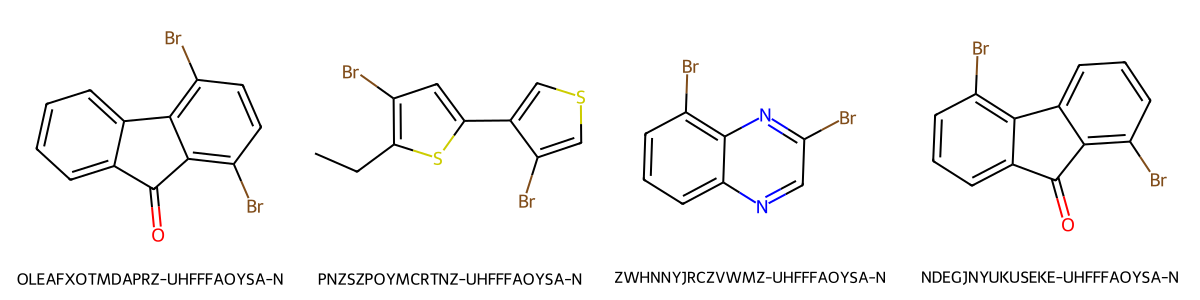

In [5]:
# plot some example of precursors
from rdkit import Chem
from rdkit.Chem import Draw

mol_list = []
mol_label = []
df_to_plot = df_precursors.sample(4)
df_to_plot["mol_opt_smiles"] = df_to_plot["mol_opt"].apply(lambda x : Chem.MolFromSmiles(Chem.MolToSmiles(x)))
mol_list.extend(df_to_plot["mol_opt_smiles"].values)
mol_label.extend(df_to_plot["InChIKey"].values)
# Draw molecules
img = Draw.MolsToGridImage(mol_list, molsPerRow=4, subImgSize=(300, 300),legends=[f"{label}" for label in mol_label])  # adjust molsPerRow and subImgSize as needed
img




To define the search space we can set the conditions on the building blocks and the syntax to follow. 

Below we can also use an interactive feature to change the conditions and visualise its impact on the precalculated search space

In [6]:
#%%  generate the search space
from stk_search import SearchSpace

importlib.reload(SearchSpace)

number_of_fragments = 6
target_name = "target" # specify the target name ( here target refers to the combined property)
aim = 1.0 # specify the target value

SP = SearchSpace.SearchSpace(number_of_fragments=number_of_fragments,df=df_precursors,generation_type="conditional")
print(SP.syntax)
print(SP.conditions_list)

[0, 1, 2, 3, 4, 5]
[[], [], [], [], [], []]


In [7]:
# save the search space
save_dir = "SearchSpace"
id = "test"
os.makedirs(save_dir, exist_ok=True)
pickle.dump(SP, open(save_dir+f"/SearchSpace_{id}.pkl", "wb"))
print(" saved to ", save_dir+f"/SearchSpace_{id}.pkl")

 saved to  SearchSpace/SearchSpace_test.pkl


## Add conditions
the syntax to add conditions on the precursors; for each position of the fragments, we can add a condition on the precursors in the form :

['property_name' #condition# value]

The property name need to be in the precursors dataframe


In [8]:
df_precursors

,electron affinity (eV),homo lumo_gap (eV),ionisation potential (eV),total energy (au)_x,HOMO-LUMO GAP (eV),total energy (au)_y,InChIKey,mol_opt,Atom_num
0,3.0685,0.095166,9.1140,-56.555859,1.672081,-56.265024,GVYASUPVXDSGHN-UQCOIBPSSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be47c01ea0>,22
1,2.8466,0.038435,9.3325,-56.536670,2.258122,-56.253990,HNRHIGPDSSXEJA-FARCUNLSSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be49c449a0>,22
2,2.9365,0.072094,9.2252,-56.533763,2.009171,-56.247781,SNMJIXVGAOBXCS-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be49c449f0>,22
3,2.5901,0.064465,8.9842,-48.098467,2.153852,-47.825214,LWMBLJLODRWDDF-NYYWCZLTSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be49c44a40>,22
4,2.5596,0.076792,8.8405,-48.091982,1.967541,-47.819849,BJFIUKSBVAJFOJ-WTKPLQERSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be49c44a90>,22
...,...,...,...,...,...,...,...,...,...
454,2.8649,0.303920,8.8200,-46.042615,1.728313,-45.759263,KHLIODULWQMOCD-BHQIHCQQSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be4757c950>,19
455,2.7657,0.137263,8.4200,-57.708005,1.695953,-57.428297,NHVFWNNWOUGGQJ-MLPAPPSSSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be4757c9a0>,28
456,2.9198,0.110731,9.0317,-52.335833,1.705240,-52.050464,QUOCUHYOMIUQNJ-OQFOIZHKSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be4757c9f0>,22
457,2.4304,0.105255,8.5325,-55.322053,1.931887,-55.054669,PTRYVXYLNANOHT-WTKPLQERSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be4757ca40>,26


In [9]:

SP.conditions_list = [
    ["'ionisation potential (eV)'#<=#6.5"],
    ["'ionisation potential (eV)'#<=#6.5"],
    ["'ionisation potential (eV)'#<=#6.5"],
    ["'ionisation potential (eV)'#<=#6.5"],
    ["'ionisation potential (eV)'#<=#6.5"],
    ["'ionisation potential (eV)'#<=#6.5"],
]


In [10]:
# save the search space
import pickle

save_dir = "data/input/STK_SearchSpace"
id = "test_limited"
os.makedirs(save_dir, exist_ok=True)
pickle.dump(SP, open(save_dir+f"/SearchSpace_{id}.pkl", "wb"))
print(" saved to ", save_dir+f"/SearchSpace_{id}.pkl")

 saved to  data/input/STK_SearchSpace/SearchSpace_test_limited.pkl


In [11]:

print(f"size of the search space is : {SP.get_space_size():.2e}")
SP.df_precursors.head()


size of the search space is : 9.40e+14


,electron affinity (eV),homo lumo_gap (eV),ionisation potential (eV),total energy (au)_x,HOMO-LUMO GAP (eV),total energy (au)_y,InChIKey,mol_opt,Atom_num
0,3.0685,0.095166,9.1140,-56.555859,1.672081,-56.265024,GVYASUPVXDSGHN-UQCOIBPSSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be47c01ea0>,22
1,2.8466,0.038435,9.3325,-56.536670,2.258122,-56.253990,HNRHIGPDSSXEJA-FARCUNLSSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be49c449a0>,22
2,2.9365,0.072094,9.2252,-56.533763,2.009171,-56.247781,SNMJIXVGAOBXCS-UHFFFAOYSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be49c449f0>,22
3,2.5901,0.064465,8.9842,-48.098467,2.153852,-47.825214,LWMBLJLODRWDDF-NYYWCZLTSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be49c44a40>,22
4,2.5596,0.076792,8.8405,-48.091982,1.967541,-47.819849,BJFIUKSBVAJFOJ-WTKPLQERSA-N,<rdkit.Chem.rdchem.Mol object at 0x70be49c44a90>,22


## Using the prior information and an iteractive tool to set the search space

In [12]:
df_total_path = "data_example/Molecule_database/30K_benchmark_150524.csv"
df_total_new = pd.read_csv(df_total_path)
print(df_total_new.columns)
df_total_new , df_precursors= database_utils.load_data_from_file(df_total_path, df_precursors_path,add_feature_frag=True)
df_total_new["target"] = (
        -np.abs(df_total_new["ES1"] - 3)
        - np.abs(df_total_new["ionisation potential (eV)"] - 5.5)
        + np.log10(df_total_new["fosc1"])
    )

Index(['InChIKey', 'InChIKey_0', 'InChIKey_1', 'InChIKey_2', 'InChIKey_3',
       'InChIKey_4', 'InChIKey_5', 'num_BB', '_id_x', 'Host IP_x',
       'electron affinity (eV)', 'homo lumo_gap (eV)',
       'ionisation potential (eV)', 'total energy (au)', 'cal_folder_x',
       'xtb_cal_folder', '_id_y', 'Excited state energy (eV)',
       'Excited state oscillator strength', 'Host IP_y', 'cal_folder_y', 'ES1',
       'fosc1', 'target', '2d_tani_pca_1', '2d_tani_pca_2', 'PCA1'],
      dtype='object')


In [13]:
#%%  generate the search space
from stk_search import SearchedSpace

importlib.reload(SearchedSpace)

number_of_fragments = 6
target_name = "target" # specify the target name ( here target refers to the combined property)
aim = 1.0 # specify the target value

SP = SearchedSpace.SearchedSpace(number_of_fragments=number_of_fragments,df=df_precursors,generation_type="conditional")
SP.generate_interactive_condition_v2(df_total=df_total_new,properties_to_plot=["electron affinity (eV)","target"])